<a href="https://colab.research.google.com/github/tjy2202/Personal_training/blob/main/%EB%B9%85%EB%8D%B0%EC%9D%B4%ED%84%B0_%EA%B4%80%EA%B4%91%EC%BD%94%EB%93%9C_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 신한카드 데이터

##### 0

In [1]:
#코랩기준 한글
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from google.colab import drive
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial import ConvexHull
import numpy as np

sns.set_style('whitegrid')
plt.rc('font', family='NanumBarunGothic') 

sns.set(font="NanumBarunGothic", 
        rc={"axes.unicode_minus":False},
        style='whitegrid')

drive.mount('/gdrive', force_remount=True)
warnings.filterwarnings('ignore')
plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /gdrive


In [2]:
shin_df_raw = pd.read_csv('/gdrive/MyDrive/data/NATIVE.txt',sep='|')

##### 0.5

In [3]:
shin_df_raw = shin_df_raw[shin_df_raw.ta_ym >= 201901]

In [4]:
shin_df_raw = shin_df_raw.dropna(subset = ['v1','v2'])

In [5]:
shin_df_raw = shin_df_raw[['v1','v2','gb2','ta_ym','vlm','usec']]

In [6]:
shin_df_raw['ta_ym'] = shin_df_raw['ta_ym'].astype('str')
shin_df_raw['diff_area'] = shin_df_raw.v1 == shin_df_raw.v2
shin_df_raw['diff_area'] = list(map(int, shin_df_raw['diff_area']))
shin_df_raw

,v1,v2,gb2,ta_ym,vlm,usec,diff_area
24524704,세종,세종,종합쇼핑,201901,1878919479,63579,1
24524705,대전,세종,외식,201901,69452328,2952,0
24524706,서울,세종,외식,201901,9267020,286,0
24524707,경남,세종,종합쇼핑,201901,603499,20,0
24524708,충북,세종,종합쇼핑,201901,107638881,2379,0
...,...,...,...,...,...,...,...
52714749,울산,부산,유흥,202104,65910,15,0
52714750,경남,부산,체험,202012,38325,5,0
52714751,울산,부산,사진촬영,202104,101400,5,0
52714752,대전,부산,패션쇼핑,202103,45720,5,0


##### 1

In [7]:
def diff_area(n):
  if n == 0:
    return 0
  else:
    return 1

x = shin_df_raw.groupby(['v1','gb2','ta_ym']).sum() 
x = x.reset_index()
x['index'] = x.v1 + '_' + x.gb2
x['diff_area'] = list(map(diff_area, x['diff_area']))
x = x.drop(columns=['v1','gb2'])
x = x[['index','ta_ym','vlm','usec','diff_area']]
x['vlm'] = x.vlm / x.usec #인당 평균 사용 금액
x = x.iloc[:,:-1]
x

,index,ta_ym,vlm,usec
0,강원_골프,201901,47631.735850,46167
1,강원_골프,201902,56981.006167,52699
2,강원_골프,201903,72661.769010,74159
3,강원_골프,201904,78219.701708,72647
4,강원_골프,201905,77297.542022,83290
...,...,...,...,...
13614,충북_헬스,202101,161441.921110,20763
13615,충북_헬스,202102,118653.275649,32146
13616,충북_헬스,202103,124951.364365,44395
13617,충북_헬스,202104,116158.416321,44312


In [8]:
#shin_df_raw = 0 #ram 처리

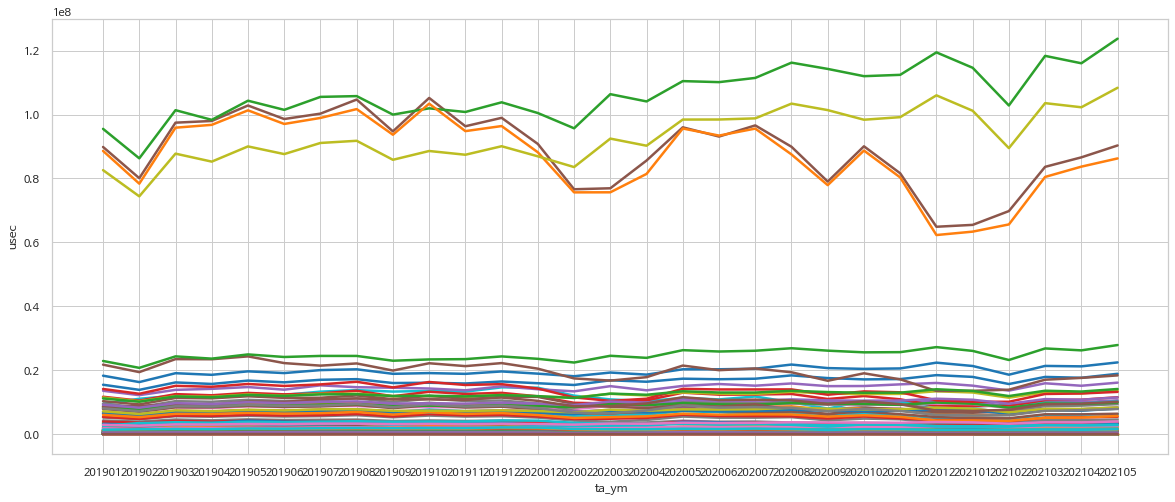

In [9]:
plt.figure(figsize=(20,8))
sns.lineplot(data=x,x='ta_ym',y='usec',hue='index', palette="tab10", linewidth=2.5,legend=None)

In [10]:
y = x.pivot_table(index=['ta_ym'], columns=['index'],values=['vlm','usec']).fillna(0).unstack(level=1).reset_index()
x = y[y.level_0  == 'usec'].iloc[:,1:]
y = y[y.level_0  == 'vlm'].iloc[:,1:]
x = pd.merge(x,y,on=['index','ta_ym'])
x = x.rename(columns={'0_x':'usec','0_y':'vlm'})
x

,index,ta_ym,usec,vlm
0,강원_골프,201901,46167.0,47631.735850
1,강원_골프,201902,52699.0,56981.006167
2,강원_골프,201903,74159.0,72661.769010
3,강원_골프,201904,72647.0,78219.701708
4,강원_골프,201905,83290.0,77297.542022
...,...,...,...,...
13799,충북_헬스,202101,20763.0,161441.921110
13800,충북_헬스,202102,32146.0,118653.275649
13801,충북_헬스,202103,44395.0,124951.364365
13802,충북_헬스,202104,44312.0,116158.416321


In [11]:
cols = x.columns[2:4]
g = x.groupby('index')[cols]
min_, max_ = g.transform('min'), g.transform('max')
x[cols + '_scale'] = (x[cols] - min_) / (max_ - min_)
x

,index,ta_ym,usec,vlm,usec_scale,vlm_scale
0,강원_골프,201901,46167.0,47631.735850,0.000000,0.000000
1,강원_골프,201902,52699.0,56981.006167,0.098611,0.255687
2,강원_골프,201903,74159.0,72661.769010,0.422585,0.684530
3,강원_골프,201904,72647.0,78219.701708,0.399758,0.836530
4,강원_골프,201905,83290.0,77297.542022,0.560432,0.811310
...,...,...,...,...,...,...
13799,충북_헬스,202101,20763.0,161441.921110,0.124514,0.813240
13800,충북_헬스,202102,32146.0,118653.275649,0.457379,0.084887
13801,충북_헬스,202103,44395.0,124951.364365,0.815569,0.192093
13802,충북_헬스,202104,44312.0,116158.416321,0.813142,0.042419


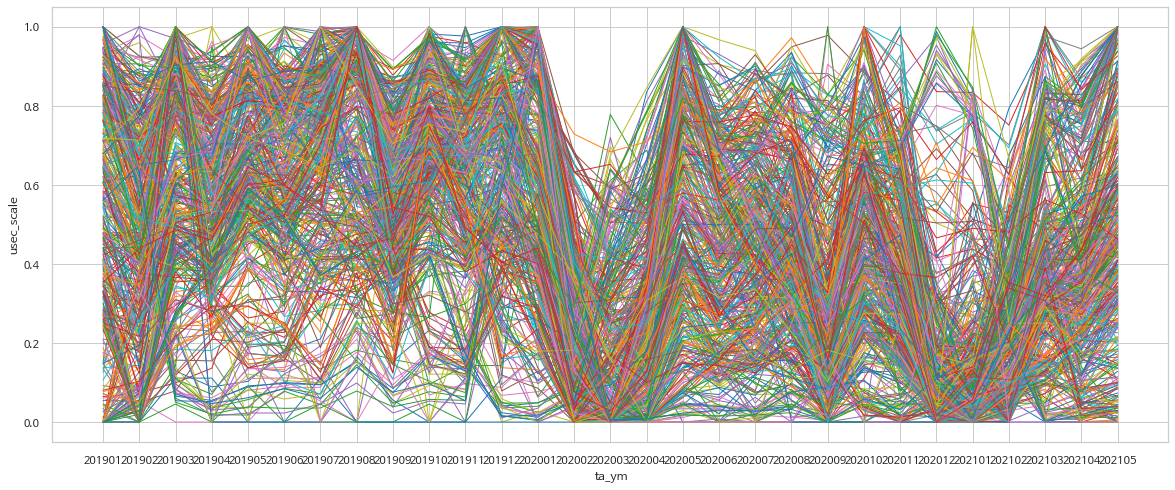

In [12]:
plt.figure(figsize=(20,8))
sns_plot = sns.lineplot(data=x,x='ta_ym',y='usec_scale',hue='index', palette="tab10", linewidth=1,legend=None)

In [13]:
x['ta_ym'] = x['ta_ym'].astype('int')
left_x_df = x[x.ta_ym < 202002].drop(columns=['ta_ym'])
right_x_df = x[x.ta_ym >= 202002].drop(columns=['ta_ym'])
left_x_df = left_x_df.groupby(left_x_df['index']).mean()
right_x_df = right_x_df.groupby(right_x_df['index']).mean()
x_df = pd.merge(left_x_df, right_x_df, on=left_x_df.index)
x_df['diff_vlm'], x_df['diff_usec'] = x_df.vlm_scale_x - x_df.vlm_scale_y, x_df.usec_scale_x - x_df.usec_scale_y
x_df = x_df.drop(columns=['vlm_x','usec_x',	'vlm_y',	'usec_y', 'vlm_scale_x',	'usec_scale_x',	'vlm_scale_y',	'usec_scale_y'])
x_df

,key_0,diff_vlm,diff_usec
0,강원_골프,-0.119727,-0.258435
1,강원_공연관람,-0.314888,0.613642
2,강원_관광쇼핑,0.472172,0.680455
3,강원_교육훈련,0.014486,0.221384
4,강원_교통,0.250404,0.683680
...,...,...,...
471,충북_종교활동,0.014992,-0.011335
472,충북_종합쇼핑,-0.025856,-0.310346
473,충북_체험,-0.211699,0.254007
474,충북_패션쇼핑,-0.165689,0.314812


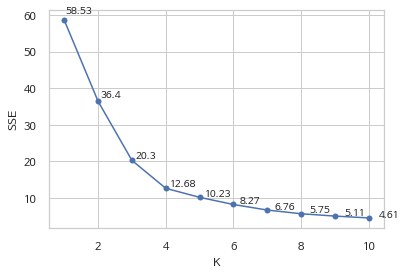

In [14]:
model = KMeans(random_state=100)

def elbow(X):
    sse = []

    for i in range(1,11):
        km = KMeans(n_clusters=i,algorithm='auto', random_state=100)
        km.fit(X)
        sse.append(km.inertia_)

    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    for n in range(len(sse)):
      plt.text((n+1) * 1.03, sse[n] * 1.03, round(sse[n],2))
    plt.show()

elbow(x_df[['diff_usec','diff_vlm']])

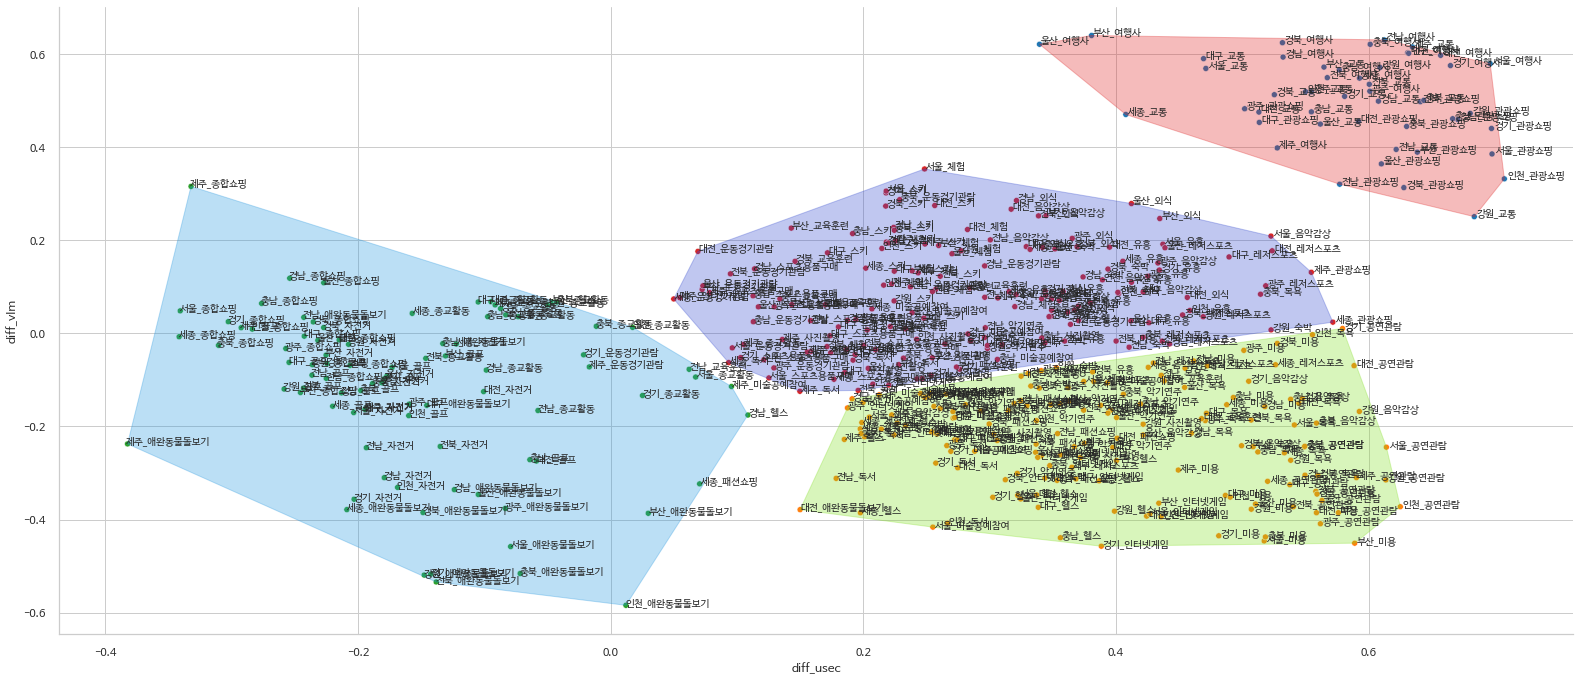

In [15]:
kmeans = KMeans(n_clusters=4) 
predict = kmeans.fit_predict(x_df[['diff_usec','diff_vlm']])
x_df['predict'] = predict

sns_plot = sns.relplot(x='diff_usec',y='diff_vlm',hue='predict',data=x_df, palette="tab10", legend=None);

for n in range(x_df.shape[0]):
  plt.text(x_df['diff_usec'][n]*1.003, x_df['diff_vlm'][n]*1.003, x_df['key_0'][n])

sns_plot.fig.set_figwidth(25);
sns_plot.fig.set_figheight(10);

colors = ['#DF2020', '#81DF20', '#2095DF','#3047CE','#AA30BB']

for i in x_df['predict'].unique():
    points = x_df[x_df.predict == i][['diff_usec', 'diff_vlm']].values

    hull = ConvexHull(points)

    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])

    plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])


In [16]:
x_df

,key_0,diff_vlm,diff_usec,predict
0,강원_골프,-0.119727,-0.258435,2
1,강원_공연관람,-0.314888,0.613642,1
2,강원_관광쇼핑,0.472172,0.680455,0
3,강원_교육훈련,0.014486,0.221384,3
4,강원_교통,0.250404,0.683680,0
...,...,...,...,...
471,충북_종교활동,0.014992,-0.011335,2
472,충북_종합쇼핑,-0.025856,-0.310346,2
473,충북_체험,-0.211699,0.254007,1
474,충북_패션쇼핑,-0.165689,0.314812,1


##### moving

In [17]:
z = shin_df_raw.groupby(['diff_area','v1','gb2','ta_ym']).sum().reset_index()
z['index'] = z.v1 + '_' + z.gb2
z = z[['index','ta_ym','usec','diff_area']]
z['ta_ym'] = z['ta_ym'].astype('int')
z = z[z.ta_ym >= 202002]
z

,index,ta_ym,usec,diff_area
13,강원_골프,202002,9816,0
14,강원_골프,202003,12100,0
15,강원_골프,202004,14514,0
16,강원_골프,202005,18549,0
17,강원_골프,202006,18326,0
...,...,...,...,...
26566,충북_헬스,202101,17998,1
26567,충북_헬스,202102,28226,1
26568,충북_헬스,202103,38133,1
26569,충북_헬스,202104,38372,1


In [18]:
cols = z.columns[2:3]
g = z.groupby('index')[cols]
min_, max_ = g.transform('min'), g.transform('max')
z[cols] = (z[cols] - min_) / (max_ - min_)
z

,index,ta_ym,usec,diff_area
13,강원_골프,202002,0.044435,0
14,강원_골프,202003,0.070673,0
15,강원_골프,202004,0.098404,0
16,강원_골프,202005,0.144758,0
17,강원_골프,202006,0.142196,0
...,...,...,...,...
26566,충북_헬스,202101,0.376752,1
26567,충북_헬스,202102,0.619381,1
26568,충북_헬스,202103,0.854394,1
26569,충북_헬스,202104,0.860064,1


In [19]:
z[z['index'] == '강원_골프']

,index,ta_ym,usec,diff_area
13,강원_골프,202002,0.044435,0
14,강원_골프,202003,0.070673,0
15,강원_골프,202004,0.098404,0
16,강원_골프,202005,0.144758,0
17,강원_골프,202006,0.142196,0
18,강원_골프,202007,0.140645,0
19,강원_골프,202008,0.107193,0
20,강원_골프,202009,0.110719,0
21,강원_골프,202010,0.147319,0
22,강원_골프,202011,0.125171,0


In [20]:
y = z.pivot_table(index=['diff_area','ta_ym'], columns=['index'],values=['usec']).fillna(0).reset_index().set_index('ta_ym')
z_0 = y[y.diff_area == 0].drop(columns='diff_area').unstack().reset_index()[['index','ta_ym',0]].rename(columns={0:'usec'})
z_1 = y[y.diff_area == 1].drop(columns='diff_area').unstack().reset_index()[['index','ta_ym',0]].rename(columns={0:'usec'})

df = pd.merge(z_0,z_1, on='index')
df['usec'] = df.usec_y - df.usec_x
df = df[['index','ta_ym_x','usec']]
df = df.groupby(['index']).mean().reset_index()
df = df[['index','usec']]
df = pd.merge(x_df[['key_0','diff_usec']].rename(columns={'key_0':'index'}),df,how='left', on='index').fillna(0)
df

,index,diff_usec,usec
0,강원_골프,-0.258435,0.674920
1,강원_공연관람,0.613642,0.144942
2,강원_관광쇼핑,0.680455,-0.464751
3,강원_교육훈련,0.221384,0.736372
4,강원_교통,0.683680,-0.779153
...,...,...,...
471,충북_종교활동,-0.011335,-0.145137
472,충북_종합쇼핑,-0.310346,-0.496447
473,충북_체험,0.254007,-0.158428
474,충북_패션쇼핑,0.314812,0.401780


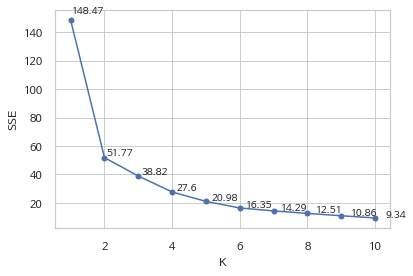

In [21]:
model = KMeans(random_state=100)

def elbow(X):
    sse = []

    for i in range(1,11):
        km = KMeans(n_clusters=i,algorithm='auto', random_state=100)
        km.fit(X)
        sse.append(km.inertia_)

    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    for n in range(len(sse)):
      plt.text((n+1) * 1.03, sse[n] * 1.03, round(sse[n],2))
    plt.show()

elbow(df[['diff_usec','usec']])

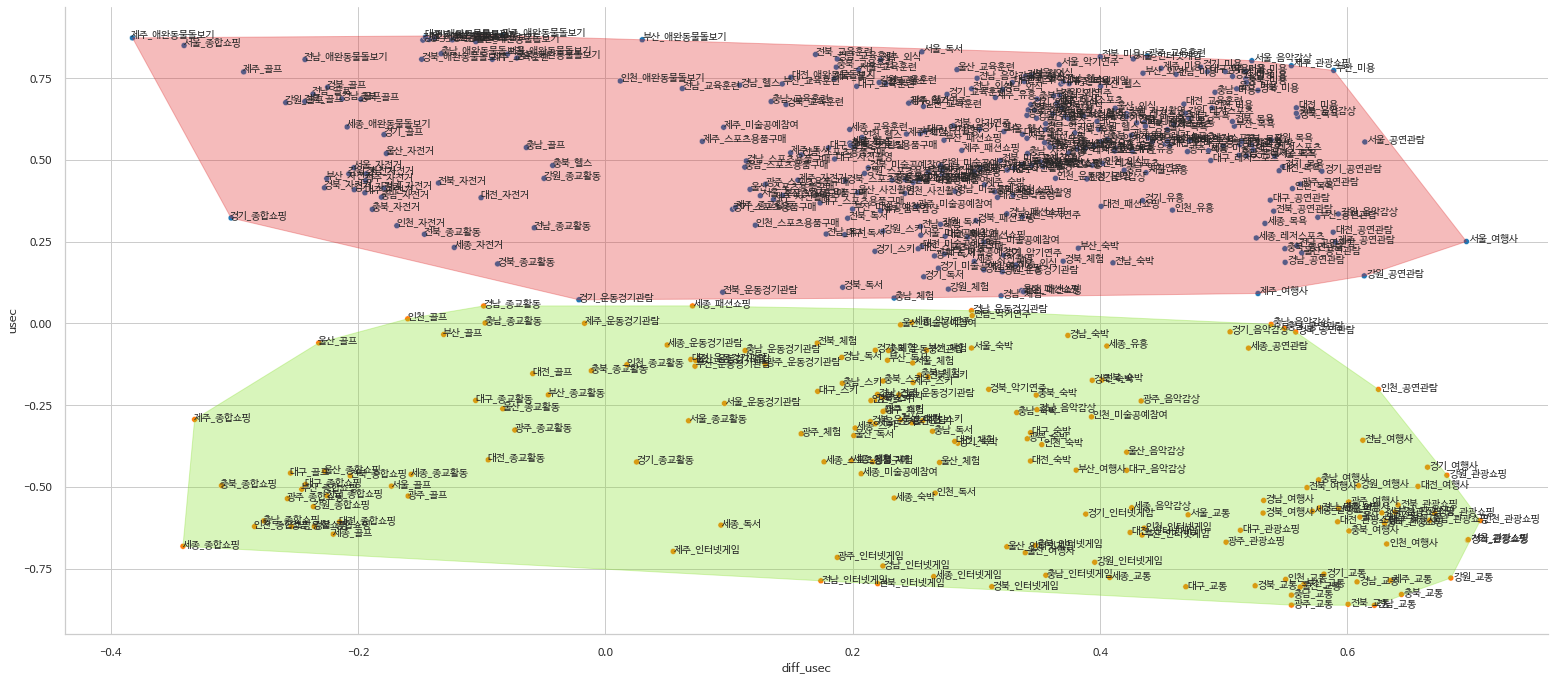

In [22]:
kmeans = KMeans(n_clusters=2)
predict = kmeans.fit_predict(df[['diff_usec','usec']])
df['predict'] = predict

sns_plot = sns.relplot(x='diff_usec',y='usec',hue='predict',data=df, palette="tab10", legend=None);

for n in range(df.shape[0]):
  plt.text(df['diff_usec'][n]*1.003, df['usec'][n]*1.003, df['index'][n])

sns_plot.fig.set_figwidth(25);
sns_plot.fig.set_figheight(10);

colors = ['#DF2020', '#81DF20', '#2095DF','#3047CE','#AA30BB']

for i in df['predict'].unique():
    points = df[df.predict == i][['diff_usec', 'usec']].values

    hull = ConvexHull(points)

    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])

    plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])


##### moving

In [23]:
z = shin_df_raw.groupby(['diff_area','v1','gb2','ta_ym']).sum().reset_index()
z['index'] = z.v1 + '_' + z.gb2
z = z[['index','ta_ym','usec','diff_area']]
z['ta_ym'] = z['ta_ym'].astype('int')
z = z[z.ta_ym < 202002]
z

,index,ta_ym,usec,diff_area
0,강원_골프,201901,8504,0
1,강원_골프,201902,9734,0
2,강원_골프,201903,14807,0
3,강원_골프,201904,15051,0
4,강원_골프,201905,17315,0
...,...,...,...,...
26550,충북_헬스,201909,19804,1
26551,충북_헬스,201910,20387,1
26552,충북_헬스,201911,19158,1
26553,충북_헬스,201912,21438,1


In [24]:
cols = z.columns[2:3]
g = z.groupby('index')[cols]
min_, max_ = g.transform('min'), g.transform('max')
z[cols] = (z[cols] - min_) / (max_ - min_)
z

,index,ta_ym,usec,diff_area
0,강원_골프,201901,0.000000,0
1,강원_골프,201902,0.021175,0
2,강원_골프,201903,0.108508,0
3,강원_골프,201904,0.112708,0
4,강원_골프,201905,0.151684,0
...,...,...,...,...
26550,충북_헬스,201909,0.593259,1
26551,충북_헬스,201910,0.619081,1
26552,충북_헬스,201911,0.564645,1
26553,충북_헬스,201912,0.665633,1


In [25]:
z[z['index'] == '강원_골프']

,index,ta_ym,usec,diff_area
0,강원_골프,201901,0.000000,0
1,강원_골프,201902,0.021175,0
2,강원_골프,201903,0.108508,0
3,강원_골프,201904,0.112708,0
4,강원_골프,201905,0.151684,0
5,강원_골프,201906,0.142473,0
6,강원_골프,201907,0.121626,0
7,강원_골프,201908,0.146278,0
8,강원_골프,201909,0.133194,0
9,강원_골프,201910,0.182878,0


In [26]:
y = z.pivot_table(index=['diff_area','ta_ym'], columns=['index'],values=['usec']).fillna(0).reset_index().set_index('ta_ym')
z_0 = y[y.diff_area == 0].drop(columns='diff_area').unstack().reset_index()[['index','ta_ym',0]].rename(columns={0:'usec'})
z_1 = y[y.diff_area == 1].drop(columns='diff_area').unstack().reset_index()[['index','ta_ym',0]].rename(columns={0:'usec'})

df = pd.merge(z_0,z_1, on='index')
df['usec'] = df.usec_y - df.usec_x
df = df[['index','ta_ym_x','usec']]
df = df.groupby(['index']).mean().reset_index()
df = df[['index','usec']]
df = pd.merge(x_df[['key_0','diff_usec']].rename(columns={'key_0':'index'}),df,how='left', on='index').fillna(0)
df

,index,diff_usec,usec
0,강원_골프,-0.258435,0.730396
1,강원_공연관람,0.613642,-0.332088
2,강원_관광쇼핑,0.680455,-0.818298
3,강원_교육훈련,0.221384,0.877120
4,강원_교통,0.683680,-0.942990
...,...,...,...
471,충북_종교활동,-0.011335,-0.210337
472,충북_종합쇼핑,-0.310346,-0.093100
473,충북_체험,0.254007,-0.354764
474,충북_패션쇼핑,0.314812,0.572916


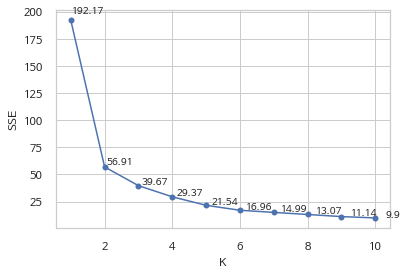

In [27]:
model = KMeans(random_state=100)

def elbow(X):
    sse = []

    for i in range(1,11):
        km = KMeans(n_clusters=i,algorithm='auto', random_state=100)
        km.fit(X)
        sse.append(km.inertia_)

    plt.plot(range(1,11), sse, marker='o')
    plt.xlabel('K')
    plt.ylabel('SSE')
    for n in range(len(sse)):
      plt.text((n+1) * 1.03, sse[n] * 1.03, round(sse[n],2))
    plt.show()

elbow(df[['diff_usec','usec']])

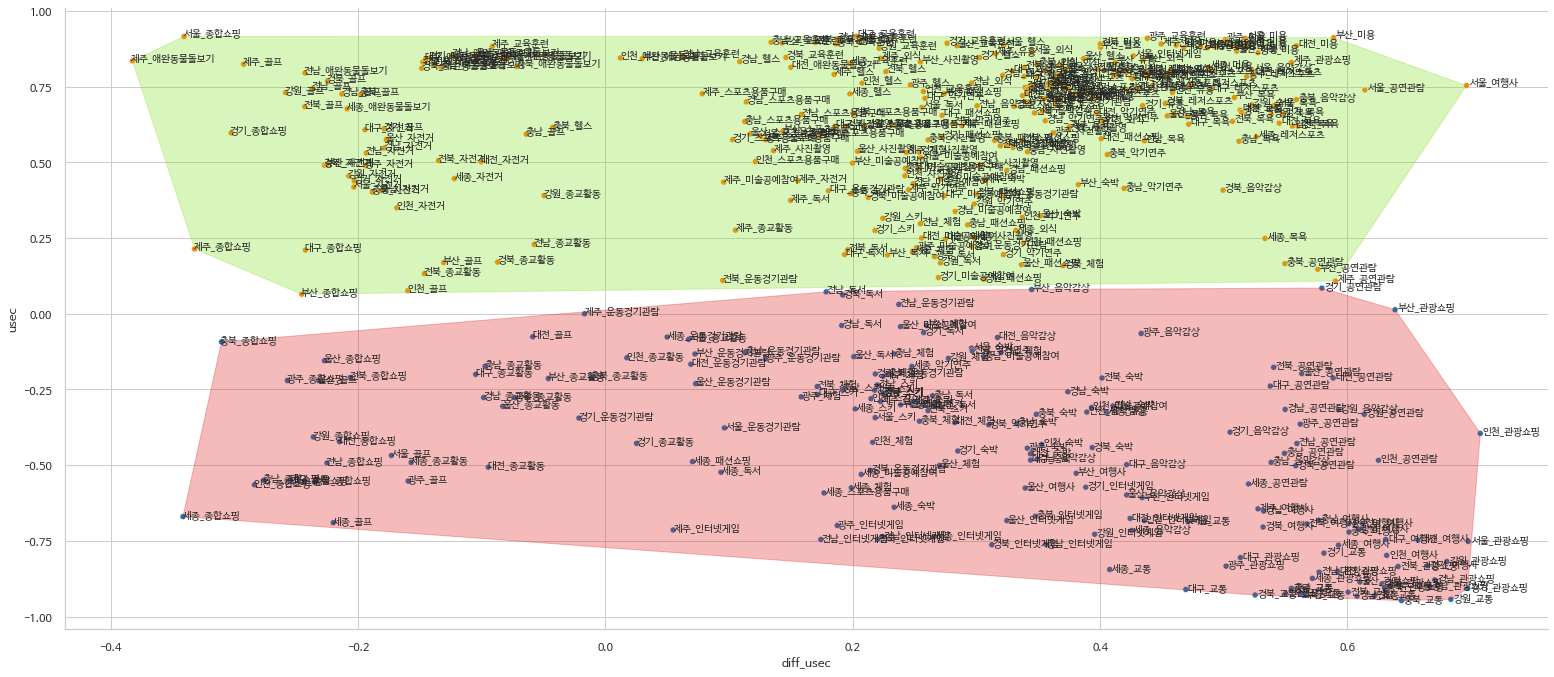

In [28]:
kmeans = KMeans(n_clusters=2)
predict = kmeans.fit_predict(df[['diff_usec','usec']])
df['predict'] = predict

sns_plot = sns.relplot(x='diff_usec',y='usec',hue='predict',data=df, palette="tab10", legend=None);

for n in range(df.shape[0]):
  plt.text(df['diff_usec'][n]*1.003, df['usec'][n]*1.003, df['index'][n])

sns_plot.fig.set_figwidth(25);
sns_plot.fig.set_figheight(10);

colors = ['#DF2020', '#81DF20', '#2095DF','#3047CE','#AA30BB']

for i in df['predict'].unique():
    points = df[df.predict == i][['diff_usec', 'usec']].values

    hull = ConvexHull(points)

    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])

    plt.fill(x_hull, y_hull, alpha=0.3, c=colors[i])


#### 여가데이터

In [ ]:
!pip install pyreadstat #spss 파일을 읽기 위한 pyreadstat install
rest_df = pd.read_spss('/gdrive/MyDrive/data/1. 2020년 국민여가활동조사데이터_공표용.sav')

     |████████████████████████████████| 2.5 MB 5.2 MB/s 


In [ ]:
x = [] #필요 데이터 선정
for i in rest_df.columns.values:
  x.append(i.lower())
rest_df.columns = x

a = '''ID
DM11
Q2_1_N2
Q2_3_1
Q2_6_1
Q2_1_N2_M2
Q2_3_2
Q2_6_2
Q2_1_N2_M3
Q2_3_3
Q2_6_3
Q2_1_N2_M4
Q2_3_4
Q2_6_4
Q2_1_N2_M5
Q2_3_5
Q2_6_5
Q26_1
Q26_2
Q26_3
Q26_4
Q26_5
Q26_6
Q26_7
Q27_1
Q27_2
Q27_3
Q27_4
Q27_5
Q27_6
Q27_7
Q41
DM2
DM8
DM12'''.lower().split('\n')

rest_df = rest_df[a]
#rest_df[a].head(10) #사용할데이터 목록 #지역 활동한 여가(?) 나이대 소득 장애여부 만족도 (여가정책 만족도, 중요도)

m = ['id',	'지역',	'여가 정책 중요도 - 여가시설의 다양성',	'여가 정책 중요도 - 질 좋은 여가프로그램 개발 및 보급',	'여가 정책 중요도 - 여가 관련 전문인력 양성 및 배치',
     '여가 정책 중요도 - 여가관련 동호회 육성 및 지원',	'여가 정책 중요도 - 소외계층 여가생활 지원',	'여가 정책 중요도 - 여가관련 법규와 제도 개선',	'여가 정책 중요도 - 공휴일과 휴가를 법적으로 보장',
     '여가 정책 만족도 - 여가시설의 다양성',	'여가 정책 만족도 - 질 좋은 여가프로그램 개발 및 보급', '여가 정책 만족도 - 여가 관련 전문인력 양성 및 배치',	'여가 정책 만족도 - 여가관련 동호회 육성 및 지원',
     '여가 정책 만족도 - 소외계층 여가생활 지원',	'여가 정책 만족도 - 여가관련 법규와 제도 개선',	'여가 정책 만족도 - 공휴일과 휴가를 법적 보장',
     '만 나이',	'연령대',	'가구 소득',	'장애여부',	'여가활동',	'여가활동 참여빈도',	'여가활동 만족도']
l = [0,1]
for i in range(17,35):
  l.append(i)

n = l.copy()

j = [2,3,4]
for k in j:
  n.append(k)
a = rest_df.iloc[:,n]
a.columns = m

i = 0

for _ in range(4):
  
  n = l.copy()

  j = [5+(i*3),6+(i*3),7+(i*3)]
  for k in j:
    n.append(k)
  print(i,n)
  b = rest_df.iloc[:,n]
  b.columns = m

  c = pd.concat([a,b], axis=0)

  a = c.copy()
  i += 1

def sp(x):
  x = str(x)
  return x.split('.',1)[0]

def sp_s(x):
  x = str(x)
  return int(x.split(' ',1)[0])

c['여가활동'] = list(map(sp,c['여가활동'])) #10088 * 5 => 50440
c = c[c['여가활동'] != 'nan']   # 50440 - 'nan'인 값 제거
c['여가활동'] = list(map(int,c['여가활동']))

for i in range(14):
  c.iloc[:,i+2] = list(map(sp_s,c.iloc[:,i+2]))
c['여가활동 만족도'] = list(map(sp_s,c['여가활동 만족도']))
c

0 [0, 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 5, 6, 7]
1 [0, 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 8, 9, 10]
2 [0, 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 11, 12, 13]
3 [0, 1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 14, 15, 16]


,id,지역,여가 정책 중요도 - 여가시설의 다양성,여가 정책 중요도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 중요도 - 여가 관련 전문인력 양성 및 배치,여가 정책 중요도 - 여가관련 동호회 육성 및 지원,여가 정책 중요도 - 소외계층 여가생활 지원,여가 정책 중요도 - 여가관련 법규와 제도 개선,여가 정책 중요도 - 공휴일과 휴가를 법적으로 보장,여가 정책 만족도 - 여가시설의 다양성,여가 정책 만족도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 만족도 - 여가 관련 전문인력 양성 및 배치,여가 정책 만족도 - 여가관련 동호회 육성 및 지원,여가 정책 만족도 - 소외계층 여가생활 지원,여가 정책 만족도 - 여가관련 법규와 제도 개선,여가 정책 만족도 - 공휴일과 휴가를 법적 보장,만 나이,연령대,가구 소득,장애여부,여가활동,여가활동 참여빈도,여가활동 만족도
0,2.0,충북,7,6,7,6,6,6,4,4,4,4,4,4,3,3,64.0,60대,100~200만원,해당사항없음,74,매일,6
1,4.0,충북,7,7,7,6,6,4,4,4,4,4,4,4,4,4,81.0,70세 이상,100~200만원,장애등록,74,매일,7
2,5.0,충북,6,6,5,4,4,4,4,4,4,4,4,4,4,4,77.0,70세 이상,100~200만원,해당사항없음,74,매일,7
3,6.0,충북,7,6,6,6,6,6,6,4,4,4,3,4,3,4,73.0,70세 이상,100~200만원,해당사항없음,74,매일,6
4,13.0,충북,5,5,5,4,6,4,4,4,4,4,4,4,4,4,81.0,70세 이상,100만원 미만,장애등록,74,매일,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10083,15001.0,전남,6,7,7,5,4,6,4,3,3,3,4,5,4,4,23.0,20대,600만원 이상,해당사항없음,75,매일,5
10084,15002.0,전남,6,7,6,4,4,4,6,4,4,4,4,3,4,5,23.0,20대,500~600만원,해당사항없음,86,한 달에 2~3번,7
10085,15007.0,전남,4,7,7,4,4,4,4,4,4,4,4,4,4,4,18.0,15-19세,600만원 이상,해당사항없음,84,매일,6
10086,15009.0,전남,4,4,4,4,4,4,4,4,4,4,4,4,4,4,18.0,15-19세,500~600만원,해당사항없음,86,한 달에 1번,6


In [ ]:
one = [38,39,40,41,42,43,44,45,46,47,48]
two = [1,2,9,13,16,17,18,19,20,21,22,23,25,26,27,28,32,33,34,37,53,55,60,61,62,63,64,68,69,77,80,82,85,86,87]
three = [3,4,5,6,7,8,10,11,12,14,15,29,30,49,50,51,54,57,58,59,65,66,67,70,72,78]
four = [24,31,35,36,52,56,71,73,74,75,76,79,81,83,84]

def cluster(x):
  if x in one:
    return 1 #관광쇼핑 교통 여행사(여행)
  elif x in two:
    return 2 #외식 스키 유흥 스포츠용품 구매 체험 운동경기관람 숙박 교육훈련 음악감상 (유흥 스포츠 교육)
  elif x in three: #1이들어가 있었음 ????
    return 3 #공연관람 미용 목욕 패션쇼핑 인터넷게임 악기연주 헬스 미술공예참여 독서 사진촬영 (자기계발, 취미)
  elif x in four:
    return 4 #종합쇼핑 골프 종교활동 자전거 애완동물돌보기 (집이나, 코로나 영향없는 밖에서 하는 활동)
  else:
    return 0
    
c['cluster'] = list(map(cluster, c['여가활동']))
print(c[c['cluster'] == 0].shape)
c = c[c['cluster'] != 0]

c = c.replace('70세 이상',7).replace('30대',3).replace('50대',5).replace('60대',6).replace('40대',4).replace('20대',2).replace('15-19세',1)
c = c.replace('100만원 미만',1).replace('100~200만원',2).replace('200~300만원',3).replace('300~400만원',4).replace('400~500만원',5).replace('500~600만원',6).replace('600만원 이상',7)
c = c.replace('해당사항없음',3).replace('미등록',2).replace('장애등록',1)
c = c.replace('매일',1).replace('일주일에 몇 번, 매일은 아님',2).replace('한 달에 2~3번',3).replace('한 달에 1번',4).replace('몇 달에 1번',5).replace('기타',6)
c = c.replace('서울',1).replace('부산',2).replace('대구',3).replace('인천',4).replace('광주',5).replace('대전',6).replace('울산',7).replace('세종',8)
c = c.replace('경기',9).replace('강원',10).replace('충북',11).replace('충남',12).replace('전북',13).replace('전남',14).replace('경북',15).replace('경남',16).replace('제주',17)
c

(56, 24)


,id,지역,여가 정책 중요도 - 여가시설의 다양성,여가 정책 중요도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 중요도 - 여가 관련 전문인력 양성 및 배치,여가 정책 중요도 - 여가관련 동호회 육성 및 지원,여가 정책 중요도 - 소외계층 여가생활 지원,여가 정책 중요도 - 여가관련 법규와 제도 개선,여가 정책 중요도 - 공휴일과 휴가를 법적으로 보장,여가 정책 만족도 - 여가시설의 다양성,여가 정책 만족도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 만족도 - 여가 관련 전문인력 양성 및 배치,여가 정책 만족도 - 여가관련 동호회 육성 및 지원,여가 정책 만족도 - 소외계층 여가생활 지원,여가 정책 만족도 - 여가관련 법규와 제도 개선,여가 정책 만족도 - 공휴일과 휴가를 법적 보장,만 나이,연령대,가구 소득,장애여부,여가활동,여가활동 참여빈도,여가활동 만족도,cluster
0,2.0,11,7,6,7,6,6,6,4,4,4,4,4,4,3,3,64.0,6,2,3,74,1,6,4
1,4.0,11,7,7,7,6,6,4,4,4,4,4,4,4,4,4,81.0,7,2,1,74,1,7,4
2,5.0,11,6,6,5,4,4,4,4,4,4,4,4,4,4,4,77.0,7,2,3,74,1,7,4
3,6.0,11,7,6,6,6,6,6,6,4,4,4,3,4,3,4,73.0,7,2,3,74,1,6,4
4,13.0,11,5,5,5,4,6,4,4,4,4,4,4,4,4,4,81.0,7,1,1,74,1,7,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10083,15001.0,14,6,7,7,5,4,6,4,3,3,3,4,5,4,4,23.0,2,7,3,75,1,5,4
10084,15002.0,14,6,7,6,4,4,4,6,4,4,4,4,3,4,5,23.0,2,6,3,86,3,7,2
10085,15007.0,14,4,7,7,4,4,4,4,4,4,4,4,4,4,4,18.0,1,7,3,84,1,6,4
10086,15009.0,14,4,4,4,4,4,4,4,4,4,4,4,4,4,4,18.0,1,6,3,86,4,6,2


In [ ]:
#https://www.thinkdatascience.com/post/2019-12-16-introducing-python-package-gower/
!pip install gower
import gower

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

  Created wheel for gower: filename=gower-0.0.5-py3-none-any.whl size=4231 sha256=59c79cc947d81f867a8681519cf675ba84998ff3a1635310f637eb02d8252a38
  Stored in directory: /root/.cache/pip/wheels/3e/f9/9a/67122a959a424e9cbb4557a8366c871a30e31cd75f0d003db4
Successfully built gower


In [ ]:
c[c.id == 95]

,id,지역,여가 정책 중요도 - 여가시설의 다양성,여가 정책 중요도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 중요도 - 여가 관련 전문인력 양성 및 배치,여가 정책 중요도 - 여가관련 동호회 육성 및 지원,여가 정책 중요도 - 소외계층 여가생활 지원,여가 정책 중요도 - 여가관련 법규와 제도 개선,여가 정책 중요도 - 공휴일과 휴가를 법적으로 보장,여가 정책 만족도 - 여가시설의 다양성,여가 정책 만족도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 만족도 - 여가 관련 전문인력 양성 및 배치,여가 정책 만족도 - 여가관련 동호회 육성 및 지원,여가 정책 만족도 - 소외계층 여가생활 지원,여가 정책 만족도 - 여가관련 법규와 제도 개선,여가 정책 만족도 - 공휴일과 휴가를 법적 보장,만 나이,연령대,가구 소득,장애여부,여가활동,여가활동 참여빈도,여가활동 만족도,cluster
4541,95.0,12,6,6,4,4,6,6,6,6,6,5,5,6,6,6,36.0,3,4,3,58,1,5,3
4541,95.0,12,6,6,4,4,6,6,6,6,6,5,5,6,6,6,36.0,3,4,3,59,1,5,3
4541,95.0,12,6,6,4,4,6,6,6,6,6,5,5,6,6,6,36.0,3,4,3,74,1,4,4
4541,95.0,12,6,6,4,4,6,6,6,6,6,5,5,6,6,6,36.0,3,4,3,86,3,5,2
4541,95.0,12,6,6,4,4,6,6,6,6,6,5,5,6,6,6,36.0,3,4,3,47,5,5,1


In [ ]:
!pip install scikit_posthocs

     |████████████████████████████████| 43 kB 1.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37903 sha256=c7cd236483ac73cee0e5fcf2a4eb21145d4235652f23ff95eef55dee6b339dbd
  Stored in directory: /root/.cache/pip/wheels/b8/21/e6/f39794d4a6ee3d3cc5146ca80b5cd949452ad4a8fde9f6b9fc
Successfully built scikit-posthocs


##### c1

In [ ]:
#https://velog.io/@pyose95/Data-Analysis ANOVA검정 Python 로드맵
c1 = c[c.cluster == 1]
#c1 = c1.iloc[:,[0,1,17,18,19,21,22]]
c1['id'] = c1.id.astype('int')
c1 = c1.sort_values('id')
c1 = c1.set_index('id')

c1['연령대'] = c1['연령대'].astype('object')
c1['가구 소득'] = c1['가구 소득'].astype('object')
c1['장애여부'] = c1['장애여부'].astype('object')
c1['여가활동 참여빈도'] = c1['여가활동 참여빈도'].astype('object')
c1['지역'] = c1['지역'].astype('object')
c1

#c1['여가활동 참여빈도'].value_counts()
#c1.describe()

,지역,여가 정책 중요도 - 여가시설의 다양성,여가 정책 중요도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 중요도 - 여가 관련 전문인력 양성 및 배치,여가 정책 중요도 - 여가관련 동호회 육성 및 지원,여가 정책 중요도 - 소외계층 여가생활 지원,여가 정책 중요도 - 여가관련 법규와 제도 개선,여가 정책 중요도 - 공휴일과 휴가를 법적으로 보장,여가 정책 만족도 - 여가시설의 다양성,여가 정책 만족도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 만족도 - 여가 관련 전문인력 양성 및 배치,여가 정책 만족도 - 여가관련 동호회 육성 및 지원,여가 정책 만족도 - 소외계층 여가생활 지원,여가 정책 만족도 - 여가관련 법규와 제도 개선,여가 정책 만족도 - 공휴일과 휴가를 법적 보장,만 나이,연령대,가구 소득,장애여부,여가활동,여가활동 참여빈도,여가활동 만족도,cluster
id,,,,,,,,,,,,,,,,,,,,,,,
10,11,7,6,5,4,4,5,7,5,4,4,4,4,4,3,31.0,3,6,3,48,3,7,1
11,11,7,6,6,5,5,6,4,4,4,4,4,4,4,3,66.0,6,3,3,48,2,7,1
39,15,6,6,5,5,6,5,5,3,3,4,4,4,4,4,49.0,4,4,3,39,2,5,1
39,15,6,6,5,5,6,5,5,3,3,4,4,4,4,4,49.0,4,4,3,48,2,6,1
67,11,6,6,5,2,5,4,4,6,4,5,6,7,6,5,44.0,4,5,3,41,5,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10125,9,6,7,7,6,6,7,7,5,5,5,4,3,4,5,39.0,3,6,3,41,5,5,1
10126,9,6,7,7,7,6,6,6,5,5,5,4,4,4,4,50.0,5,3,3,48,3,6,1
10135,10,6,6,6,2,4,5,5,5,4,3,4,5,5,5,56.0,5,4,3,48,5,6,1


In [ ]:
c1.iloc[:,[0,16,17,18,20,21]]

,지역,연령대,가구 소득,장애여부,여가활동 참여빈도,여가활동 만족도
id,,,,,,
10,11,3,6,3,3,7
11,11,6,3,3,2,7
39,15,4,4,3,2,5
39,15,4,4,3,2,6
67,11,4,5,3,5,7
...,...,...,...,...,...,...
10125,9,3,6,3,5,5
10126,9,5,3,3,3,6
10135,10,5,4,3,5,6


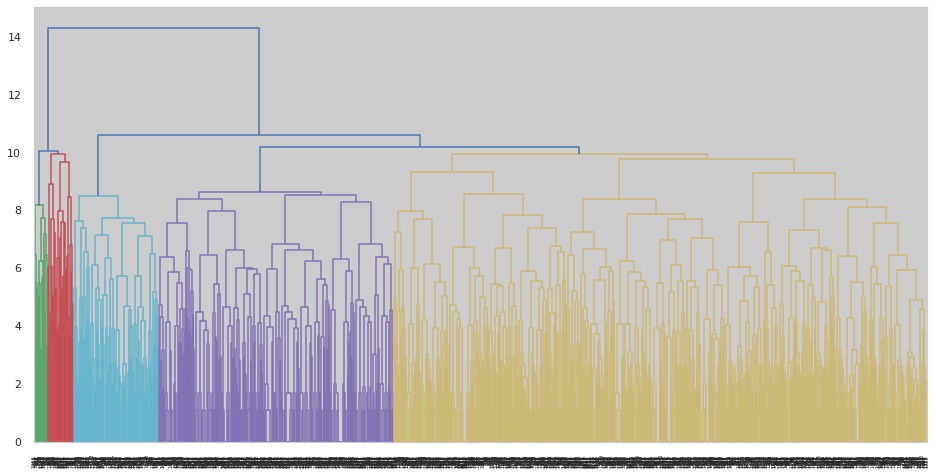

In [ ]:
dm = gower.gower_matrix(c1.iloc[:,[0,16,17,18,20,21]]) #파이썬 0.5775 R 0.5779 => 순서 코딩이잘못돼서 달라짐
Zd = linkage(dm, method='complete') #파이썬 813.5489 R 811 => 순서 코딩이잘못돼서 달라짐
#pd.DataFrame(dm)[0].value_counts()
plt.figure(figsize=(16, 8))
dendrogram(Zd)
plt.show()

In [ ]:
cld = fcluster(Zd, 5, criterion='maxclust')
c1['fcluster'] = cld
c1 

,지역,여가 정책 중요도 - 여가시설의 다양성,여가 정책 중요도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 중요도 - 여가 관련 전문인력 양성 및 배치,여가 정책 중요도 - 여가관련 동호회 육성 및 지원,여가 정책 중요도 - 소외계층 여가생활 지원,여가 정책 중요도 - 여가관련 법규와 제도 개선,여가 정책 중요도 - 공휴일과 휴가를 법적으로 보장,여가 정책 만족도 - 여가시설의 다양성,여가 정책 만족도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 만족도 - 여가 관련 전문인력 양성 및 배치,여가 정책 만족도 - 여가관련 동호회 육성 및 지원,여가 정책 만족도 - 소외계층 여가생활 지원,여가 정책 만족도 - 여가관련 법규와 제도 개선,여가 정책 만족도 - 공휴일과 휴가를 법적 보장,만 나이,연령대,가구 소득,장애여부,여가활동,여가활동 참여빈도,여가활동 만족도,cluster,fcluster
id,,,,,,,,,,,,,,,,,,,,,,,,
10,11,7,6,5,4,4,5,7,5,4,4,4,4,4,3,31.0,3,6,3,48,3,7,1,5
11,11,7,6,6,5,5,6,4,4,4,4,4,4,4,3,66.0,6,3,3,48,2,7,1,3
39,15,6,6,5,5,6,5,5,3,3,4,4,4,4,4,49.0,4,4,3,39,2,5,1,3
39,15,6,6,5,5,6,5,5,3,3,4,4,4,4,4,49.0,4,4,3,48,2,6,1,3
67,11,6,6,5,2,5,4,4,6,4,5,6,7,6,5,44.0,4,5,3,41,5,7,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10125,9,6,7,7,6,6,7,7,5,5,5,4,3,4,5,39.0,3,6,3,41,5,5,1,4
10126,9,6,7,7,7,6,6,6,5,5,5,4,4,4,4,50.0,5,3,3,48,3,6,1,4
10135,10,6,6,6,2,4,5,5,5,4,3,4,5,5,5,56.0,5,4,3,48,5,6,1,5


In [ ]:
kr = c1.iloc[:,[0,17,18,20,21,-1]]
kr

,지역,가구 소득,장애여부,여가활동 참여빈도,여가활동 만족도,fcluster
id,,,,,,
10,11,6,3,3,7,5
11,11,3,3,2,7,3
39,15,4,3,2,5,3
39,15,4,3,2,6,3
67,11,5,3,5,7,5
...,...,...,...,...,...,...
10125,9,6,3,5,5,4
10126,9,3,3,3,6,4
10135,10,4,3,5,6,5


In [ ]:
from scipy import stats 

print('1 : ', stats.shapiro(kr[kr.fcluster == 1])) #0.05보다 작아 정규성 가정 X
print('2 : ', stats.shapiro(kr[kr.fcluster == 2])) # H0 : 정규분포를 따른다, H1 : 정규분포를 따르지 않는다.
print('3 : ', stats.shapiro(kr[kr.fcluster == 3]))
print('4 : ', stats.shapiro(kr[kr.fcluster == 4]))
print('5 : ', stats.shapiro(kr[kr.fcluster == 5]))


1 :  (0.7788172960281372, 8.982324974961264e-14)
2 :  (0.8793237209320068, 3.992044596366068e-14)
3 :  (0.7320393323898315, 4.5091849220637565e-36)
4 :  (0.8794153332710266, 9.561339681781092e-41)
5 :  (0.7902108430862427, 0.0)


In [ ]:
from scipy.stats import kruskal
kruskal(kr[kr.fcluster == 1].iloc[:,:-1], kr[kr.fcluster == 2].iloc[:,:-1], kr[kr.fcluster == 3].iloc[:,:-1],
        kr[kr.fcluster == 4].iloc[:,:-1],kr[kr.fcluster == 5].iloc[:,:-1])

KruskalResult(statistic=109070.98696025864, pvalue=0.0)

In [ ]:
import scikit_posthocs as sp 
#multicomparison
sp.posthoc_dunn(kr, val_col = '여가활동 만족도', group_col='fcluster', p_adjust = 'bonferroni')
#sp.posthoc_conover(kr, val_col = '여가활동 만족도', group_col='fcluster', p_adjust = 'holm')  #dunn 형식과 같지만 z분포가 아닌 t분포를 사용함

,1,2,3,4,5
1,1.0,1.000000,1.000000,1.0,1.000000
2,1.0,1.000000,0.950141,1.0,0.473487
3,1.0,0.950141,1.000000,1.0,1.000000
4,1.0,1.000000,1.000000,1.0,1.000000
5,1.0,0.473487,1.000000,1.0,1.000000


In [ ]:
#ipa 해볼것 summary도

##### c2

In [ ]:
c2 = c[c.cluster == 2]
c2['id'] = c2.id.astype('int')
c2 = c2.sort_values('id')
c2 = c2.set_index('id')

c2['연령대'] = c2['연령대'].astype('object')
c2['가구 소득'] = c2['가구 소득'].astype('object')
c2['장애여부'] = c2['장애여부'].astype('object')
c2['여가활동 참여빈도'] = c2['여가활동 참여빈도'].astype('object')
c2['지역'] = c2['지역'].astype('object')
c2

,지역,여가 정책 중요도 - 여가시설의 다양성,여가 정책 중요도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 중요도 - 여가 관련 전문인력 양성 및 배치,여가 정책 중요도 - 여가관련 동호회 육성 및 지원,여가 정책 중요도 - 소외계층 여가생활 지원,여가 정책 중요도 - 여가관련 법규와 제도 개선,여가 정책 중요도 - 공휴일과 휴가를 법적으로 보장,여가 정책 만족도 - 여가시설의 다양성,여가 정책 만족도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 만족도 - 여가 관련 전문인력 양성 및 배치,여가 정책 만족도 - 여가관련 동호회 육성 및 지원,여가 정책 만족도 - 소외계층 여가생활 지원,여가 정책 만족도 - 여가관련 법규와 제도 개선,여가 정책 만족도 - 공휴일과 휴가를 법적 보장,만 나이,연령대,가구 소득,장애여부,여가활동,여가활동 참여빈도,여가활동 만족도,cluster
id,,,,,,,,,,,,,,,,,,,,,,,
2,11,7,6,7,6,6,6,4,4,4,4,4,4,3,3,64.0,6,2,3,86,2,7,2
2,11,7,6,7,6,6,6,4,4,4,4,4,4,3,3,64.0,6,2,3,63,2,7,2
3,11,7,7,6,4,5,5,5,6,5,5,5,6,5,6,56.0,5,3,3,63,2,5,2
3,11,7,7,6,4,5,5,5,6,5,5,5,6,5,6,56.0,5,3,3,77,1,5,2
4,11,7,7,7,6,6,4,4,4,4,4,4,4,4,4,81.0,7,2,1,63,3,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15012,5,7,7,7,6,7,7,7,4,4,4,4,4,6,6,54.0,5,3,3,64,2,7,2
15013,5,7,7,7,7,7,5,5,4,4,4,4,5,6,5,57.0,5,1,3,86,2,7,2
15013,5,7,7,7,7,7,5,5,4,4,4,4,5,6,5,57.0,5,1,3,64,2,7,2


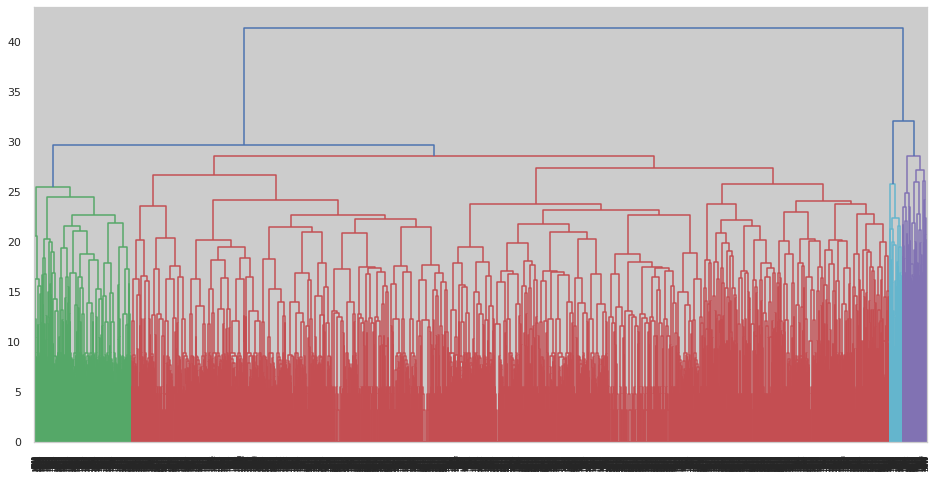

In [ ]:
dm = gower.gower_matrix(c2.iloc[:,[0,16,17,18,20,21]]) #파이썬 0.5775 R 0.5779 => 순서 코딩이잘못돼서 달라짐
Zd = linkage(dm, method='complete') #파이썬 813.5489 R 811 => 순서 코딩이잘못돼서 달라짐
#pd.DataFrame(dm)[0].value_counts()
plt.figure(figsize=(16, 8))
dendrogram(Zd)
plt.show()

In [ ]:
cld = fcluster(Zd, 5, criterion='maxclust')
c2['fcluster'] = cld

In [ ]:
kr = c2.iloc[:,[0,17,18,20,21,-1]]
kr

,지역,가구 소득,장애여부,여가활동 참여빈도,여가활동 만족도,fcluster
id,,,,,,
2,11,2,3,2,7,2
2,11,2,3,2,7,2
3,11,3,3,2,5,2
3,11,3,3,1,5,3
4,11,2,1,3,7,5
...,...,...,...,...,...,...
15012,5,3,3,2,7,2
15013,5,1,3,2,7,2
15013,5,1,3,2,7,2


In [ ]:
from scipy import stats 

print('1 : ', stats.shapiro(kr[kr.fcluster == 1]))
print('2 : ', stats.shapiro(kr[kr.fcluster == 2])) 
print('3 : ', stats.shapiro(kr[kr.fcluster == 3]))
print('4 : ', stats.shapiro(kr[kr.fcluster == 4]))
print('5 : ', stats.shapiro(kr[kr.fcluster == 5]))


1 :  (0.7741433382034302, 0.0)
2 :  (0.7690703868865967, 0.0)
3 :  (0.7946168780326843, 0.0)
4 :  (0.7852609157562256, 2.5020096639495435e-36)
5 :  (0.8374439477920532, 1.448942612111861e-42)


In [ ]:
from scipy.stats import kruskal
kruskal(kr[kr.fcluster == 1].iloc[:,:-1], kr[kr.fcluster == 2].iloc[:,:-1], kr[kr.fcluster == 3].iloc[:,:-1],
        kr[kr.fcluster == 4].iloc[:,:-1],kr[kr.fcluster == 5].iloc[:,:-1])

KruskalResult(statistic=932629.4176578983, pvalue=0.0)

In [ ]:
import scikit_posthocs as sp 
sp.posthoc_dunn(kr, val_col = '여가활동 만족도', group_col='fcluster', p_adjust = 'bonferroni')

,1,2,3,4,5
1,1.000000,2.424894e-04,1.000000e+00,1.0,0.746978
2,0.000242,1.000000e+00,4.859419e-07,1.0,1.000000
3,1.000000,4.859419e-07,1.000000e+00,1.0,1.000000
4,1.000000,1.000000e+00,1.000000e+00,1.0,1.000000
5,0.746978,1.000000e+00,1.000000e+00,1.0,1.000000


##### c3

In [ ]:
c3 = c[c.cluster == 3]
c3['id'] = c3.id.astype('int')
c3 = c3.sort_values('id')
c3 = c3.set_index('id')

c3['연령대'] = c3['연령대'].astype('object')
c3['가구 소득'] = c3['가구 소득'].astype('object')
c3['장애여부'] = c3['장애여부'].astype('object')
c3['여가활동 참여빈도'] = c3['여가활동 참여빈도'].astype('object')
c3['지역'] = c3['지역'].astype('object')
c3

,지역,여가 정책 중요도 - 여가시설의 다양성,여가 정책 중요도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 중요도 - 여가 관련 전문인력 양성 및 배치,여가 정책 중요도 - 여가관련 동호회 육성 및 지원,여가 정책 중요도 - 소외계층 여가생활 지원,여가 정책 중요도 - 여가관련 법규와 제도 개선,여가 정책 중요도 - 공휴일과 휴가를 법적으로 보장,여가 정책 만족도 - 여가시설의 다양성,여가 정책 만족도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 만족도 - 여가 관련 전문인력 양성 및 배치,여가 정책 만족도 - 여가관련 동호회 육성 및 지원,여가 정책 만족도 - 소외계층 여가생활 지원,여가 정책 만족도 - 여가관련 법규와 제도 개선,여가 정책 만족도 - 공휴일과 휴가를 법적 보장,만 나이,연령대,가구 소득,장애여부,여가활동,여가활동 참여빈도,여가활동 만족도,cluster
id,,,,,,,,,,,,,,,,,,,,,,,
1,11,7,7,6,5,5,6,6,5,5,5,4,4,5,5,67.0,6,2,3,70,1,5,3
6,11,7,6,6,6,6,6,6,4,4,4,3,4,3,4,73.0,7,2,3,58,2,7,3
6,11,7,6,6,6,6,6,6,4,4,4,3,4,3,4,73.0,7,2,3,65,2,7,3
8,11,7,7,7,7,7,7,7,3,3,4,4,3,4,4,30.0,3,6,3,65,1,6,3
8,11,7,7,7,7,7,7,7,3,3,4,4,3,4,4,30.0,3,6,3,66,1,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15017,5,7,7,6,6,7,6,6,5,5,5,5,4,6,6,64.0,6,2,3,58,1,6,3
15018,5,7,7,7,5,7,4,4,6,6,4,6,4,4,4,62.0,6,2,3,72,2,7,3
15018,5,7,7,7,5,7,4,4,6,6,4,6,4,4,4,62.0,6,2,3,50,2,7,3


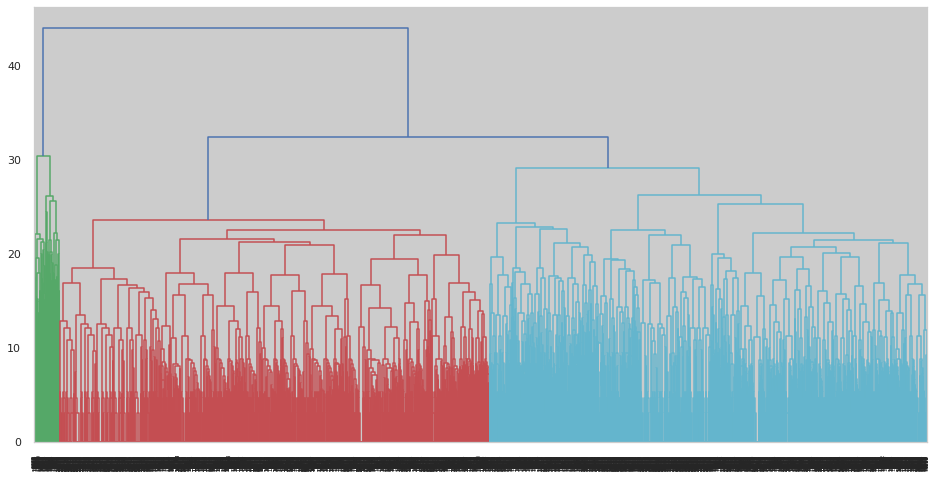

In [ ]:
dm = gower.gower_matrix(c3.iloc[:,[0,16,17,18,20,21]]) #파이썬 0.5775 R 0.5779 => 순서 코딩이잘못돼서 달라짐
Zd = linkage(dm, method='complete') #파이썬 813.5489 R 811 => 순서 코딩이잘못돼서 달라짐
#pd.DataFrame(dm)[0].value_counts()
plt.figure(figsize=(16, 8))
dendrogram(Zd)
plt.show()

In [ ]:
cld = fcluster(Zd, 5, criterion='maxclust')
c3['fcluster'] = cld

In [ ]:
kr = c3.iloc[:,[0,17,18,20,21,-1]]
kr

,지역,가구 소득,장애여부,여가활동 참여빈도,여가활동 만족도,fcluster
id,,,,,,
1,11,2,3,1,5,3
6,11,2,3,2,7,5
6,11,2,3,2,7,5
8,11,6,3,1,6,3
8,11,6,3,1,6,3
...,...,...,...,...,...,...
15017,5,2,3,1,6,3
15018,5,2,3,2,7,5
15018,5,2,3,2,7,5


In [ ]:
from scipy import stats 

print('1 : ', stats.shapiro(kr[kr.fcluster == 1]))
print('2 : ', stats.shapiro(kr[kr.fcluster == 2])) 
print('3 : ', stats.shapiro(kr[kr.fcluster == 3]))
print('4 : ', stats.shapiro(kr[kr.fcluster == 4]))
print('5 : ', stats.shapiro(kr[kr.fcluster == 5]))


1 :  (0.7319529056549072, 1.4655521915991152e-36)
2 :  (0.7716891169548035, 6.3188570043518e-37)
3 :  (0.8123149275779724, 0.0)
4 :  (0.756953775882721, 0.0)
5 :  (0.85509192943573, 0.0)


In [ ]:
from scipy.stats import kruskal
kruskal(kr[kr.fcluster == 1].iloc[:,:-1], kr[kr.fcluster == 2].iloc[:,:-1], kr[kr.fcluster == 3].iloc[:,:-1],
        kr[kr.fcluster == 4].iloc[:,:-1],kr[kr.fcluster == 5].iloc[:,:-1])

KruskalResult(statistic=810068.3083777935, pvalue=0.0)

In [ ]:
import scikit_posthocs as sp 
sp.posthoc_dunn(kr, val_col = '여가활동 만족도', group_col='fcluster', p_adjust = 'bonferroni')

,1,2,3,4,5
1,1.0,1.000000,1.000000,1.000000,1.000000
2,1.0,1.000000,0.480572,0.022299,0.341632
3,1.0,0.480572,1.000000,0.018474,1.000000
4,1.0,0.022299,0.018474,1.000000,0.081478
5,1.0,0.341632,1.000000,0.081478,1.000000


##### c4

In [ ]:
c4 = c[c.cluster == 4]
c4['id'] = c4.id.astype('int')
c4 = c4.sort_values('id')
c4 = c4.set_index('id')

c4['연령대'] = c4['연령대'].astype('object')
c4['가구 소득'] = c4['가구 소득'].astype('object')
c4['장애여부'] = c4['장애여부'].astype('object')
c4['여가활동 참여빈도'] = c4['여가활동 참여빈도'].astype('object')
c4['지역'] = c4['지역'].astype('object')
c4

,지역,여가 정책 중요도 - 여가시설의 다양성,여가 정책 중요도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 중요도 - 여가 관련 전문인력 양성 및 배치,여가 정책 중요도 - 여가관련 동호회 육성 및 지원,여가 정책 중요도 - 소외계층 여가생활 지원,여가 정책 중요도 - 여가관련 법규와 제도 개선,여가 정책 중요도 - 공휴일과 휴가를 법적으로 보장,여가 정책 만족도 - 여가시설의 다양성,여가 정책 만족도 - 질 좋은 여가프로그램 개발 및 보급,여가 정책 만족도 - 여가 관련 전문인력 양성 및 배치,여가 정책 만족도 - 여가관련 동호회 육성 및 지원,여가 정책 만족도 - 소외계층 여가생활 지원,여가 정책 만족도 - 여가관련 법규와 제도 개선,여가 정책 만족도 - 공휴일과 휴가를 법적 보장,만 나이,연령대,가구 소득,장애여부,여가활동,여가활동 참여빈도,여가활동 만족도,cluster
id,,,,,,,,,,,,,,,,,,,,,,,
1,11,7,7,6,5,5,6,6,5,5,5,4,4,5,5,67.0,6,2,3,74,1,7,4
1,11,7,7,6,5,5,6,6,5,5,5,4,4,5,5,67.0,6,2,3,52,1,5,4
1,11,7,7,6,5,5,6,6,5,5,5,4,4,5,5,67.0,6,2,3,73,2,6,4
1,11,7,7,6,5,5,6,6,5,5,5,4,4,5,5,67.0,6,2,3,81,2,7,4
2,11,7,6,7,6,6,6,4,4,4,4,4,4,3,3,64.0,6,2,3,73,2,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15019,5,7,7,7,6,7,5,6,5,5,5,4,4,5,6,69.0,6,1,3,52,1,7,4
15019,5,7,7,7,6,7,5,6,5,5,5,4,4,5,6,69.0,6,1,3,74,1,6,4
15020,5,7,7,7,7,7,5,6,5,3,3,4,4,5,6,60.0,6,1,3,74,1,7,4


In [ ]:
dm = gower.gower_matrix(c4.iloc[:,[0,16,17,18,20,21]]) #파이썬 0.5775 R 0.5779 => 순서 코딩이잘못돼서 달라짐
Zd = linkage(dm, method='complete') #파이썬 813.5489 R 811 => 순서 코딩이잘못돼서 달라짐
#pd.DataFrame(dm)[0].value_counts()
plt.figure(figsize=(16, 8))
dendrogram(Zd)
plt.show()

In [ ]:
cld = fcluster(Zd, 5, criterion='maxclust')
c4['fcluster'] = cld

In [ ]:
kr = c4.iloc[:,[0,17,18,20,21,-1]]
kr

In [ ]:
from scipy import stats 

print('1 : ', stats.shapiro(kr[kr.fcluster == 1]))
print('2 : ', stats.shapiro(kr[kr.fcluster == 2])) 
print('3 : ', stats.shapiro(kr[kr.fcluster == 3]))
print('4 : ', stats.shapiro(kr[kr.fcluster == 4]))
print('5 : ', stats.shapiro(kr[kr.fcluster == 5]))


In [ ]:
from scipy.stats import kruskal
kruskal(kr[kr.fcluster == 1].iloc[:,:-1], kr[kr.fcluster == 2].iloc[:,:-1], kr[kr.fcluster == 3].iloc[:,:-1],
        kr[kr.fcluster == 4].iloc[:,:-1],kr[kr.fcluster == 5].iloc[:,:-1])

In [ ]:
import scikit_posthocs as sp 
sp.posthoc_dunn(kr, val_col = '여가활동 만족도', group_col='fcluster', p_adjust = 'bonferroni')